# Overfitting and underfitting
In this tutorial I will familiarize myself with how to deal with underfitting or overfitting using Keras. Of course I am familiar with the concepts, which is why I will skip the long verbose intro of the tutorial. Let's dive right in.

In [2]:
import tensorflow as tf 

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile 

# Additional libraries I will use
from random import seed
from random import randint
from random import sample
seed(1)

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## Higgs dataset!
Yeah, some particle physics here. I'm excited. This dataset contains 11 million examples, with 28 features and a binary class.

In [4]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 171s 0us/step


After downloading the dataset, we repack it so that it produces automatically features and labels. In addition, instead of repacking each row individually, we make a new dataset taking batches of 10000 examples, it packs it to produce features and labels, and then splits the batches back up.

In [5]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [6]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Let's do some data inspection, shall we? (I have no idea what the steps before did.)

Are the features normal?

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


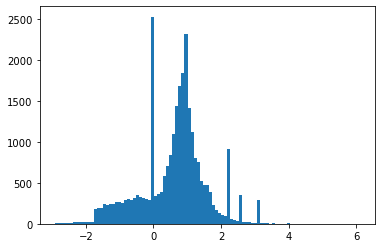

In [7]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

While the data aren't perfectly normal, this should be sufficient for the tutorial. (Why must the data be normal? The tutorial doesn't really explain what we are going to do...)

To avoid complications, let us take only the first 1000 samples for validation, and 10000 after for training, using the functions Dataset.skip and Dataset.take. The method cache() ensures that the loader does not need to re-read data from the file on each epoch.

In [8]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [9]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>